In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import ascii as astro_ascii
import pickle, scipy, copy, numpy as np, pandas as pd

#from alf_vars import *
from linterp import *
from scipy import constants
from velbroad import *
from set_pinit_priors import *
from setup import *
from vacairconv import *
from read_data import *
from getm2l import getm2l
from getmass import getmass
from getmodel import getmodel
from contnormspec import contnormspec
from getvelz import getvelz
from str2arr import str2arr
from spec_from_sum import spec_from_sum
from write_a_model import *
from func import *
from alf_constants import *

from priors import TopHat

In [2]:
alfvar = pickle.load(open('../pickle/alfvar_sspgrid_irldss3_imftype3_full.p', "rb" ))

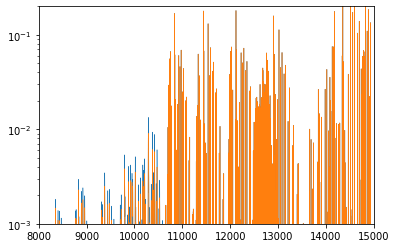

In [17]:
alfvar.

In [4]:
pos, alfvar, mspec_ = spec_from_sum('ldss3_dr246_n4055_Re4_wave6e_imf3hernoatm', 
                                   alfvar, 
                                   getsum = 'minchi2', 
                                   returnspec=True)
mspec = mspec_[1]
posarr = str2arr(switch=1, instr=pos)

In [21]:
oneplusz = (1+pos.velz/clight*1e5)
zmspec = linterp(alfvar.sspgrid.lam[:alfvar.nl_fit]*oneplusz,
                         mspec[:alfvar.nl_fit],
                         alfvar.data.lam[:alfvar.datmax])

In [20]:
pos.sigma=100
m1 = getmodel(pos, alfvar=alfvar)
print(func(alfvar, posarr))
pos.sigma=400
m2 = getmodel(pos, alfvar=alfvar)

42845.990093333545


In [13]:
sig0 = 99
lamlo = 3.8e3
lamhi = 2.4e4
f29 = np.loadtxt("{0}infiles/atm_trans.dat".format(ALF_HOME))
ltrans = np.copy(f29[:, 0])
ftrans_h2o = np.copy(f29[:, 1])
ftrans_o2 = np.copy(f29[:, 2])


In [46]:
    datmax = alfvar.datmax
    data_ires_max = np.nanmax(alfvar.data.ires)
    if  data_ires_max > 0: # CHECK
        strans = linterp(xin = alfvar.data.lam,
                         yin = alfvar.data.ires,
                         xout = ltrans)
        strans[np.where(strans<0)] = 0
        strans[np.where(strans>data_ires_max)] = data_ires_max

In [47]:
strans = np.sqrt(np.square(strans) + np.square(alfvar.smooth_trans) + 10**2)

In [55]:
        f29 = np.loadtxt("{0}infiles/radiance_lines.dat".format(ALF_HOME))
        lsky, fsky = f29[:,0], f29[:,1]

In [62]:
        smooth = linterp(alfvar.data.lam,alfvar.data.ires,alfvar.sspgrid.lam)

        temind = np.where(alfvar.sspgrid.lam<alfvar.data.lam[0])
        smooth[temind] = alfvar.data.ires[0]

        temind = np.where(alfvar.sspgrid.lam>alfvar.data.lam[-1])
        smooth[temind] = alfvar.data.ires[datmax-1]

In [64]:
sig0

99

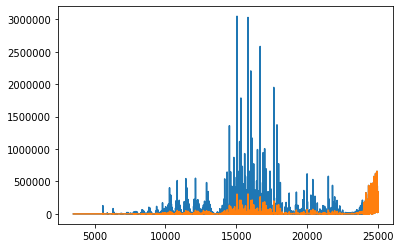

In [60]:
plt.plot(lsky, fsky)
plt.plot(lsky, alfvar.fsky)

In [7]:
sky1 = velbroad(lam = alfvar.lsky, spec = alfvar.fsky,
                sigma = sig0, minl = lamlo, maxl = lamhi,
                ires = strans, velbroad_simple =1)

ValueError: operands could not be broadcast together with shapes (39324,) (22800,) 

In [5]:
use_keys = ['velz', 'sigma', 'logage', 'zh', 'feh', 
            'ah', 'ch', 'nh', 'nah', 'mgh', 'cah', 'tih', 
            'imf1', 'imf2', 'imf3']

In [6]:
posarr = str2arr(switch=1, instr=pos, usekeys = use_keys)

In [7]:
posarr[24], posarr[25], posarr[42]

(3.4302, 3.1326, 0.1925)

In [8]:
in_posarr=posarr

In [9]:
pos, prlo, prhi = set_pinit_priors(alfvar)

In [11]:
    prloarr = str2arr(switch=1, instr = prlo)
    prhiarr = str2arr(switch=1, instr = prhi)

In [21]:
prloarr[24], prloarr[25], prloarr[42], prhiarr[24], prloarr[25], prloarr[42]

(0.5, 0.5, 0.08, 3.5, 0.5, 0.08)

In [5]:
        alfvar.filename = 'ldss3_dr246_n4055_Re4_wave6e'
        alfvar = read_data(alfvar)
        # ---- read in the SSPs and bandpass filters
        #alfvar = setup(alfvar)
        lam = np.copy(alfvar.sspgrid.lam)

        # ---- interpolate the sky emission model onto the observed wavelength grid
        if alfvar.observed_frame == 1:
            alfvar.data.sky = linterp(alfvar.lsky, alfvar.fsky, alfvar.data.lam)
            alfvar.data.sky[alfvar.data.sky<0] = 0.                               
        else:
            alfvar.data.sky[:] = tiny_number
        alfvar.data.sky[:] = tiny_number

        # ---- we only compute things up to 500A beyond the input fit region
        alfvar.nl_fit = min(max(locate(lam, alfvar.l2[-1]+500.0),0),alfvar.nl-1)

        #define the log wavelength grid used in velbroad.f90
        alfvar.dlstep = (np.log(alfvar.sspgrid.lam[alfvar.nl_fit])-
                         np.log(alfvar.sspgrid.lam[0]))/alfvar.nl_fit
        
        for i in range(alfvar.nl_fit):
            alfvar.lnlam[i] = i*alfvar.dlstep + np.log(alfvar.sspgrid.lam[0])

        # ---- masked regions have wgt=0.0.  We'll use wgt as a pseudo-error
        # ---- array in contnormspec, so turn these into large numbers
        alfvar.data.wgt = 1./(alfvar.data.wgt+tiny_number)
        alfvar.data.wgt[alfvar.data.wgt>huge_number] = huge_number
        # ---- fold the masked regions into the errors
        alfvar.data.err = alfvar.data.err * alfvar.data.wgt
        alfvar.data.err[alfvar.data.err>huge_number] = huge_number

In [6]:
    # ---- set initial params, step sizes, and prior ranges
    opos,prlo,prhi = set_pinit_priors(alfvar)
    # ---- convert the structures into their equivalent arrays
    prloarr = str2arr(switch=1, instr = prlo)
    prhiarr = str2arr(switch=1, instr = prhi)
    
    velz = getvelz(alfvar)
    opos.velz = velz
    oposarr = str2arr(switch=1, instr=opos)

In [11]:
global global_alfvar, global_prloarr, global_prhiarr
global_alfvar = copy.deepcopy(alfvar)
global_prloarr = copy.deepcopy(prloarr)
global_prhiarr = copy.deepcopy(prhiarr)

In [ ]:
key_list = ['velz', 'sigma', 'logage', 'zh', 'feh', 
                'ah', 'ch', 'nh','nah','mgh','sih','kh','cah','tih',
                'vh','crh','mnh','coh','nih','cuh','srh','bah','euh',
                'teff','imf1','imf2','logfy','sigma2','velz2',
                'logm7g','hotteff','loghot','fy_logage',
                'logemline_h','logemline_oii','logemline_oiii',
                'logemline_sii','logemline_ni','logemline_nii',
                'logtrans','jitter','logsky', 'imf3','imf4','h3','h4']

In [41]:
def log_prob(posarr):
    return -0.5*func(global_alfvar, posarr, 
                     prhiarr=global_prhiarr, 
                     prloarr=global_prloarr, 
                     usekeys=use_keys)

In [10]:
nwalkers = 128
npar = len(use_keys)
pos_emcee_in = np.empty((nwalkers, npar))
pos_emcee_in[:,:2] = oposarr[:2] + 10.0*(2.*np.random.rand(nwalkers, npar)[:,:2]-1.0)
pos_emcee_in[:,2:npar] = oposarr[2:npar] +  0.1*(2.*np.random.rand(nwalkers, npar)[:,2:npar]-1.0)

In [11]:
key_list = ['velz', 'sigma', 'logage', 'zh', 'feh', 
            'ah', 'ch', 'nh','nah','mgh','sih','kh','cah','tih',
            'vh','crh','mnh','coh','nih','cuh','srh','bah','euh',
                'teff','imf1','imf2','logfy','sigma2','velz2',
                'logm7g','hotteff','loghot','fy_logage',
                'logemline_h','logemline_oii','logemline_oiii',
                'logemline_sii','logemline_ni','logemline_nii',
                'logtrans','jitter','logsky', 'imf3','imf4','h3','h4']

default_arr = np.array([0.0, 11.0, 1.0, 0.0, 0.0,0.0,0.0,0.0, 0.0, 0.0,  
                        0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 
                        0.0, 0.0, 0.0, 0.0, 0.0, 1.3, 2.3, -4.0, 
                        11.0, 0.0, -4.0, 20.0, -4.0, 0.3, 
                        -4.0, -4.0, -4.0, -4.0, -4.0, -4.0, 
                        -4.0, 1.0, -4.0, 0.10, 0.0, 0.0, 0.0])
key_arr = np.array(key_list)

In [12]:
func(global_alfvar,pos_emcee_in[0,:], prhiarr=global_prhiarr, 
     prloarr=global_prloarr,usekeys = use_keys)

98498.43528811494

In [ ]:
import emcee, time
from multiprocessing import Pool

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, npar, log_prob, pool=pool)
    start = time.time()
    state = sampler.run_mcmc(pos_emcee_in, 100, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))  

In [11]:
import matplotlib.pyplot as plt
samples = sampler.get_chain()

NameError: name 'sampler' is not defined

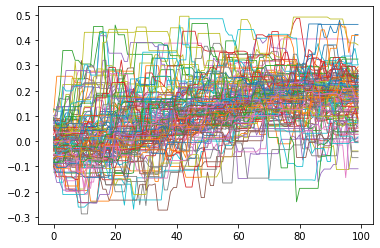

In [24]:
for i in range(samples.shape[1]):
    plt.plot(samples[:,i,8], lw=0.8)
#plt.ylim(3e3, 1e4)

In [ ]:
import cProfile
cProfile.run("func(alfvar, posarr)")

In [13]:
log_prob(posarr), log_prob(oposarr)

(-28961.565416724843, -40713.36541615539)

In [8]:
global use_keys
use_keys = ['velz', 'sigma', 'logage', 'zh',]

def log_prob(posarr):
    ln_prior = lnprior(posarr, usekeys = use_keys, 
                       prhiarr=global_prhiarr, prloarr=global_prloarr, 
                       nested = True)
    if not np.isfinite(ln_prior):
        return -np.infty
    
    return ln_prior - 0.5*func(global_alfvar, posarr, 
                     prhiarr=global_prhiarr, 
                     prloarr=global_prloarr, 
                     usekeys=use_keys)

In [9]:
import dynesty
from dynesty import NestedSampler, DynamicNestedSampler

In [12]:
def prior_transform(unit_coords, usekeys = use_keys,
                    prhiarr=global_prhiarr, prloarr=global_prloarr):    
    theta = np.empty((len(unit_coords)))
    key_arr = np.array(['velz', 'sigma', 'logage', 'zh', 'feh', 
            'ah', 'ch', 'nh','nah','mgh','sih','kh','cah','tih',
            'vh','crh','mnh','coh','nih','cuh','srh','bah','euh',
                'teff','imf1','imf2','logfy','sigma2','velz2',
                'logm7g','hotteff','loghot','fy_logage',
                'logemline_h','logemline_oii','logemline_oiii',
                'logemline_sii','logemline_ni','logemline_nii',
                'logtrans','jitter','logsky', 'imf3','imf4','h3','h4'])
    
    for i, ikey in enumerate(usekeys):
        ind = np.where(key_arr==ikey)
        a = TopHat(prloarr[ind].item(), prhiarr[ind].item())
        theta[i] = a.unit_transform(unit_coords[i])
    return theta

In [15]:
import sys, time

In [17]:
    # instantiate sampler
    dsampler = dynesty.DynamicNestedSampler(log_prob, prior_transform, len(use_keys),
                                            bound='multi', sample='unif',
                                            update_interval=0.6,
                                            pool=None, queue_size=1,
                                            walks=25, bootstrap=0)

    # generator for initial nested sampling
    ncall = dsampler.ncall
    niter = dsampler.it - 1
    tstart = time.time()
    for results in dsampler.sample_initial(nlive=100,
                                           dlogz= 0.02,
                                           maxcall= int(1e5),
                                           maxiter=None):
        (worst, ustar, vstar, loglstar, logvol,
         logwt, logz, logzvar, h, nc, worst_it,
         propidx, propiter, eff, delta_logz) = results
        if delta_logz > 1e6:
            delta_logz = np.inf
        ncall += nc
        niter += 1

        with np.errstate(invalid='ignore'):
            logzerr = np.sqrt(logzvar)
        sys.stderr.write("\riter: {:d} | batch: {:d} | nc: {:d} | "
                         "ncall: {:d} | eff(%): {:6.3f} | "
                         "logz: {:6.3f} +/- {:6.3f} | "
                         "dlogz: {:6.3f} > {:6.3f}    "
                         .format(niter, 0, nc, ncall, eff, logz,
                                 logzerr, delta_logz, 0.02))
        sys.stderr.flush()

    ndur = time.time() - tstart
    print('\ndone dynesty (initial) in {0}s'.format(ndur))

iter: 3116 | batch: 0 | nc: 1 | ncall: 11169 | eff(%): 27.899 | logz: -28444.910 +/-  0.688 | dlogz:  0.000 >  0.020      


done dynesty (initial) in 3549.481503725052s


In [71]:
dsampler = dynesty.DynamicNestedSampler(log_prob, prior_transform, 
                                        len(use_keys), 
                                        walks = 25, bound = 'multi', 
                                        npoints=200, maxcall = int(1e6))
dsampler.run_nested()

1501it [17:09,  1.46it/s, batch: 0 | bound: 0 | nc: 1 | ncall: 3531 | eff(%): 42.509 | loglstar:   -inf < -32967.273 <    inf | logz: -32976.182 +/-  0.197 | dlogz:  1.099 >  0.010]    


In [18]:
res1 = dsampler.results

In [21]:
import pickle

In [23]:
from dynesty import plotting as dyplot
res1 = pickle.load(open('../test_dynesty_res2.p', "rb" ))
use_keys = ['velz', 'sigma', 'logage', 'zh']
ndim = len(use_keys)

/Users/menggu/Library/Python/3.7/lib/python/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


(-0.02, 0.02)

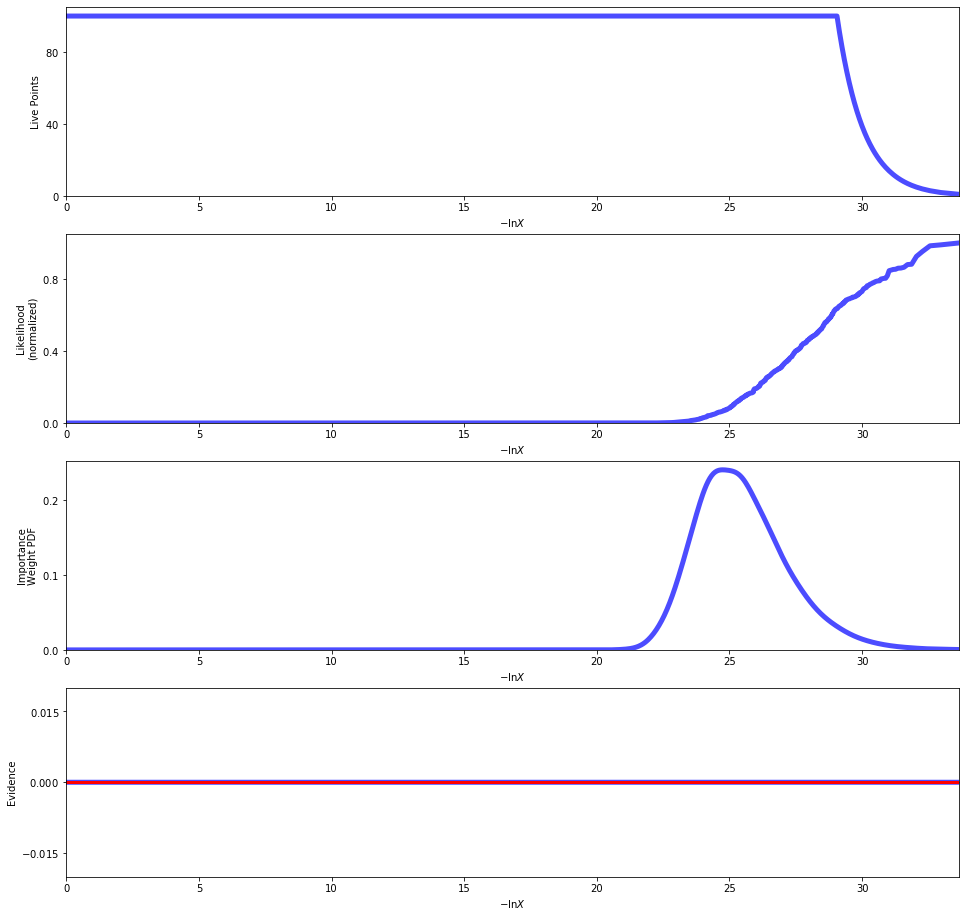

In [24]:
from dynesty import plotting as dyplot

lnz_truth = ndim * -np.log(2 * 10.)  # analytic evidence solution
fig, axes = dyplot.runplot(res1, lnz_truth=lnz_truth)  # summary (run) plot
axes[3].set_ylim(-0.02,0.02,)

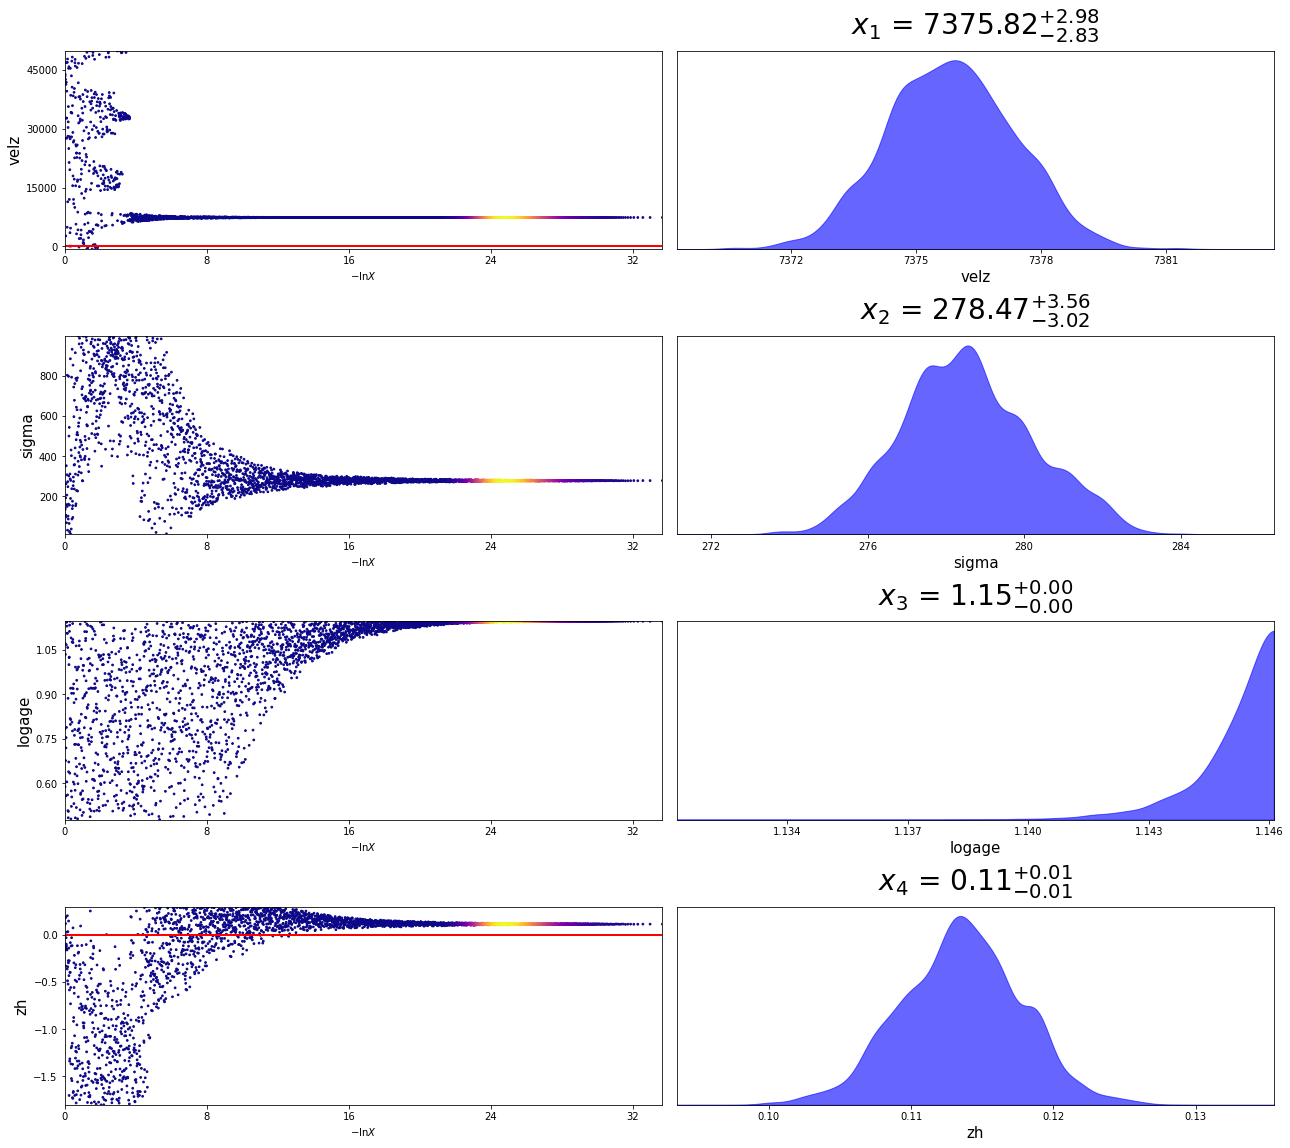

In [29]:
# plotting the static run
fig, axes = dyplot.traceplot(res1, truths=np.zeros(ndim), show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(ndim, 2, figsize=(18, ndim*4)))
fig.tight_layout()
for i, ikey in enumerate(use_keys):
    axes[i, 0].set_ylabel(ikey, fontsize=15)
    axes[i, 1].set_xlabel(ikey, fontsize=15) 

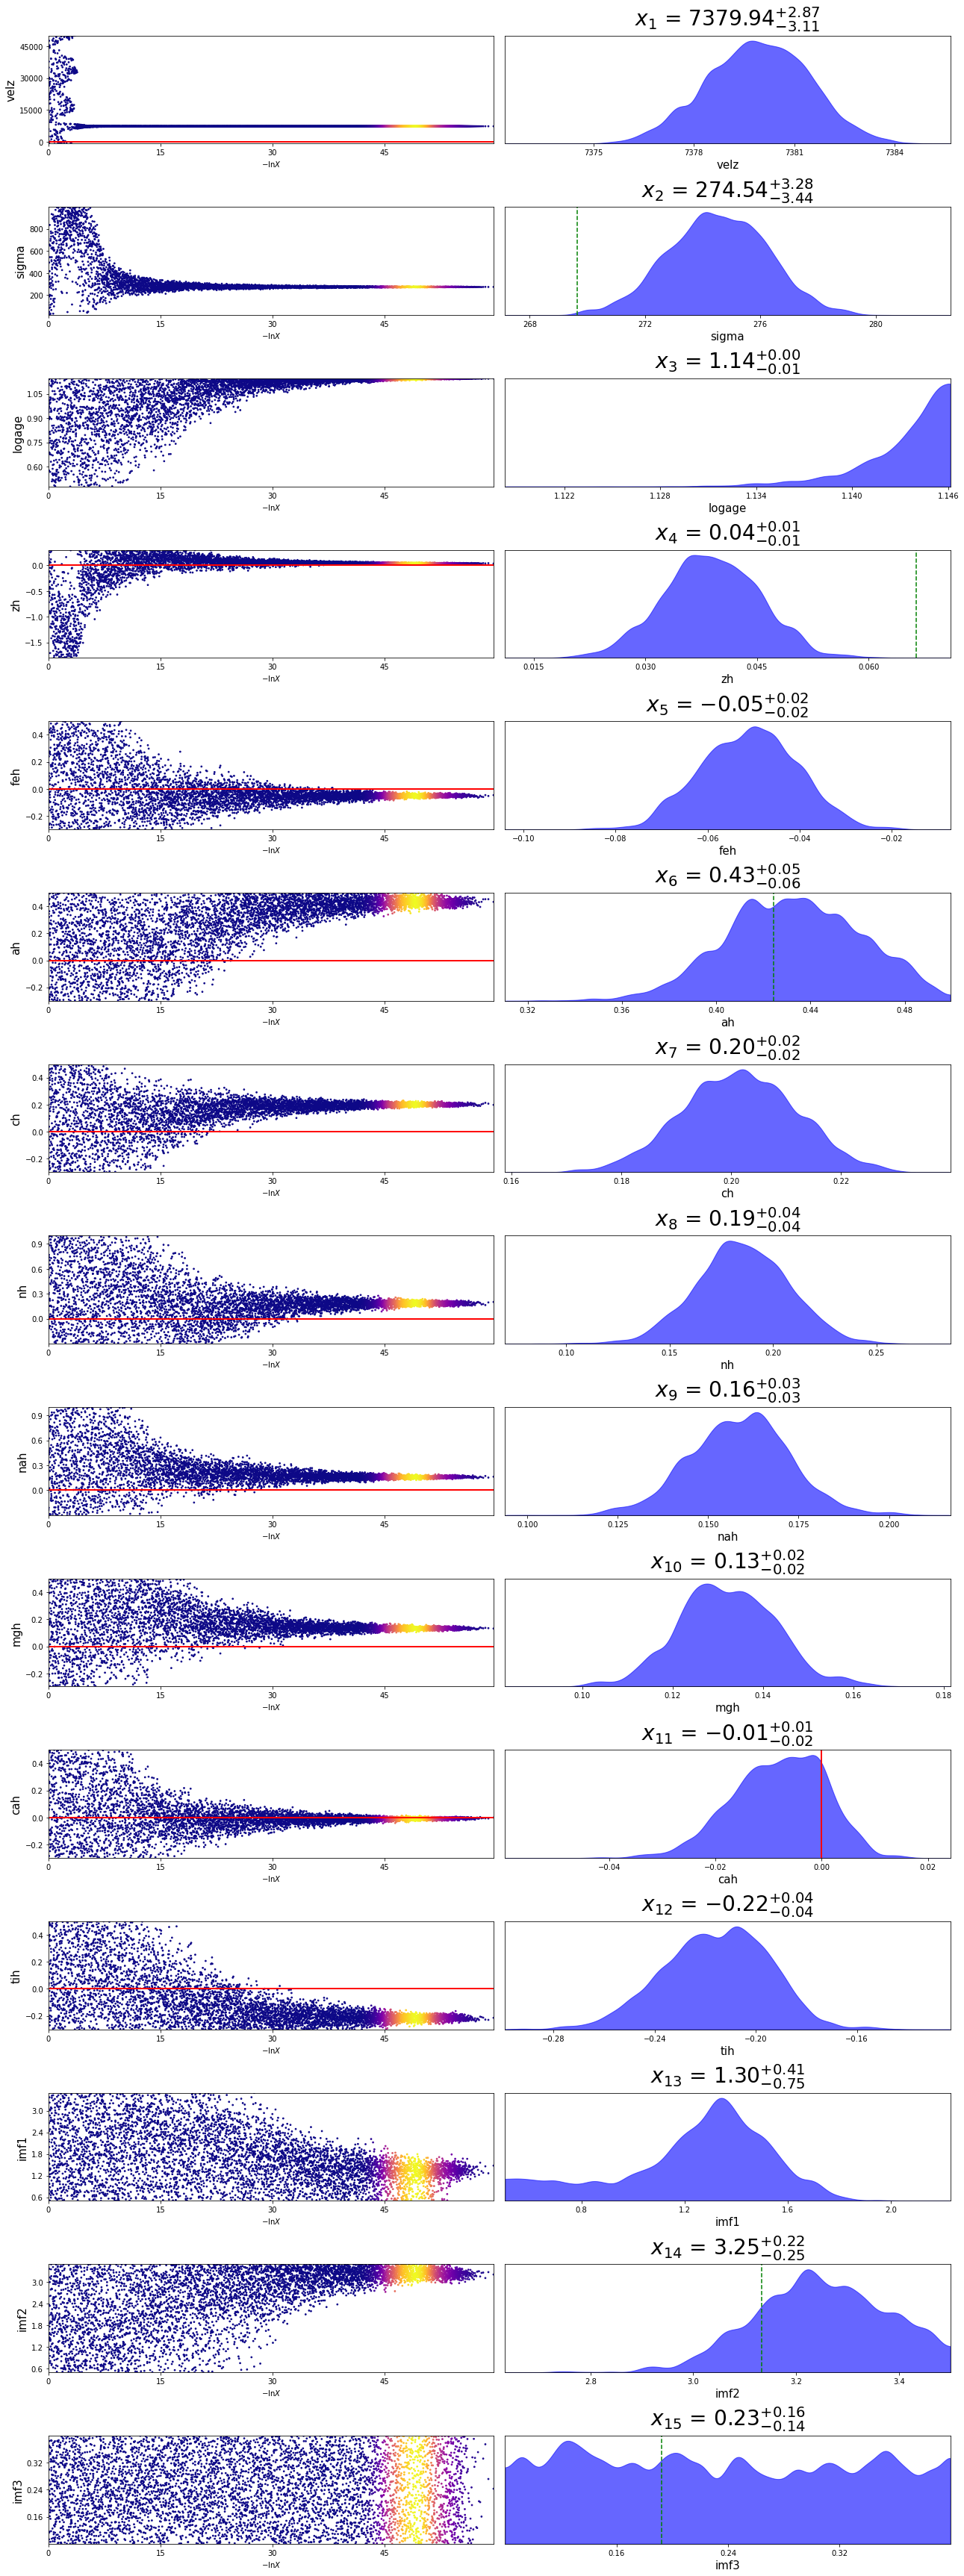

In [8]:
# plotting the static run
fig, axes = dyplot.traceplot(res1, truths=np.zeros(ndim), show_titles=True, trace_cmap='plasma',
                             title_kwargs={'fontsize': 28, 'y': 1.05}, quantiles=None,
                             fig=plt.subplots(15, 2, figsize=(18, 48)))
fig.tight_layout()
for i, ikey in enumerate(use_keys):
    axes[i, 0].set_ylabel(ikey, fontsize=15)
    axes[i, 1].set_xlabel(ikey, fontsize=15) 
    alfres_ = getattr(pos, ikey)
    if i==1:
        alfres_ = (alfres_**2+100**2)**0.5
    axes[i, 1].axvline(alfres_, ls='--', color='g')
    #axes[i, 1].set_xlim(min(alfres_, axes[i, 1].get_xlim()[0]))
    #axes[i, 1].set_xlim(max(alfres_, axes[i, 1].get_xlim()[1]))

IndexError: index 9 is out of bounds for axis 0 with size 9

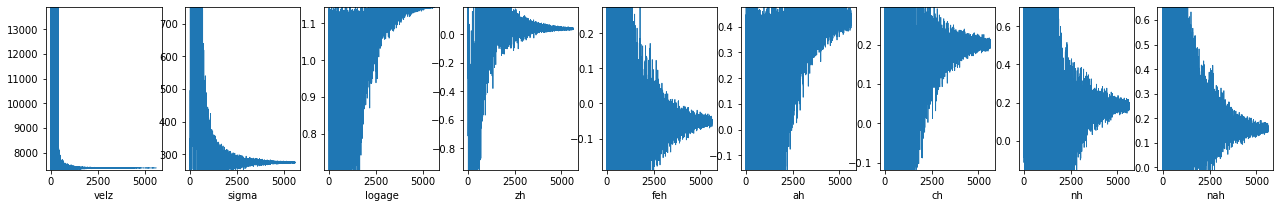

In [30]:
samples = res1.samples
fig, axl = plt.subplots(1, 9, figsize=(22, 3))
for i in range(15):
    axl[i].plot(samples[:,i], lw=0.8)
    #axl[i].set_yscale('log')
    axl[i].set_xlabel(use_keys[i])
    axl[i].set_ylim(np.nanpercentile(samples[:,i], 5), np.nanpercentile(samples[:,i], 95))

(array([ 162.,  195.,  223.,  256.,  283.,  342.,  438.,  576., 1317.,
        1833.]),
 array([0.50079615, 0.80071054, 1.10062492, 1.40053931, 1.7004537 ,
        2.00036808, 2.30028247, 2.60019685, 2.90011124, 3.20002562,
        3.49994001]),
 <a list of 10 Patch objects>)

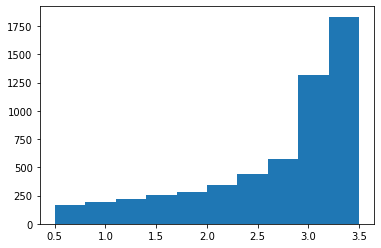

In [11]:
plt.hist(samples[:,-2])

(array([ 532.,  663., 1188., 1027.,  653.,  436.,  385.,  317.,  244.,
         180.]),
 array([0.50050582, 0.80038268, 1.10025953, 1.40013639, 1.70001325,
        1.99989011, 2.29976697, 2.59964383, 2.89952069, 3.19939754,
        3.4992744 ]),
 <a list of 10 Patch objects>)

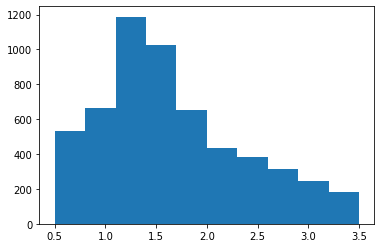

In [12]:
plt.hist(samples[:,-3])